# Titanic: Machine Learning from Disaster

In [1]:
# https://www.kaggle.com/c/titanic

In [2]:
import sklearn
import pandas as pd

In [3]:
# Загружаем данные из файлов
train = pd.read_csv('./titanic/train.csv')
test = pd.read_csv('./titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Предобработка данных

In [5]:
# Заполняем пропуски в данных медианными 
# значениями факторов на обучающей выборке
train_median = train.median()
train_imp = train.fillna(train_median)
test_imp = test.fillna(train_median)

In [6]:
# Бинаризуем категориальные признаки
CATEGORY_COL = ['Sex', 'Pclass', 'Embarked']
train_dummies = pd.get_dummies(train_imp, columns=CATEGORY_COL, drop_first=True)
test_dummies = pd.get_dummies(test_imp, columns=CATEGORY_COL, drop_first=True)

In [7]:
train_dummies.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_male,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,1,0,1,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,0,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,1,0,1,0,1


In [8]:
# Удаляем лишние столбцы
DROP_COL = ['PassengerId', 'Name', 'Ticket', 'Cabin']
TARGET_COL = 'Survived'
X_train = train_dummies.drop(DROP_COL + [TARGET_COL], axis=1)
y_train = train_dummies[TARGET_COL]
X_test = test_dummies.drop(DROP_COL, axis=1)

## Предсказание моделей для стеккинга

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

from collections import OrderedDict

import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline


def cross_val_predict_proba(estimator, X_train, y_train):
    kfold = KFold(n_splits=4, shuffle=True, random_state=None)
    return cross_val_predict(estimator, X_train, y_train, cv=kfold, method='predict_proba')

def create_submission(predicted, file_name):
    with open(file_name, 'w') as out:
        out.write('PassengerId,Survived\n')
        for passenger, y in zip(test['PassengerId'], predicted):
            out.write('%s,%s\n' % (passenger, y))

In [10]:
kfold = KFold(n_splits=5, shuffle=True, random_state=None)

### Сначала тюним RandomForest

#### Подбираме метод определения максимального количества фич

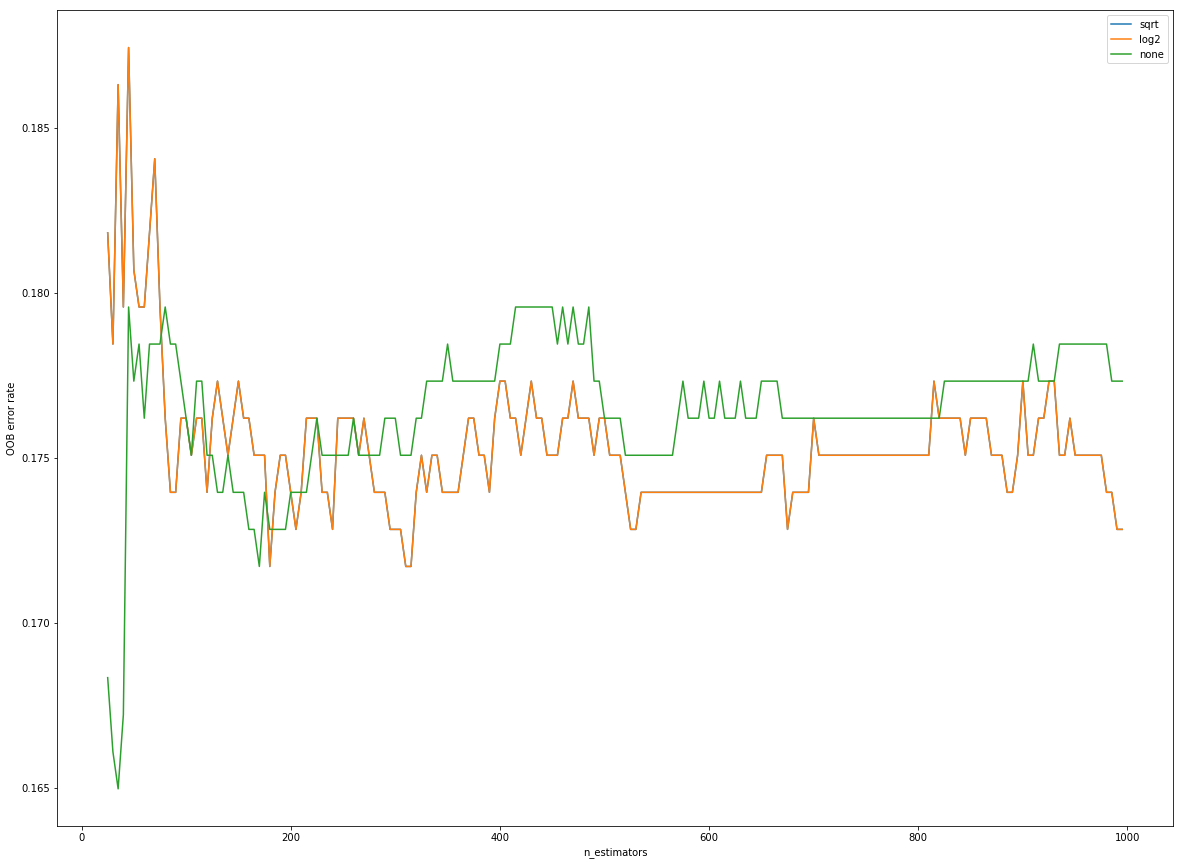

In [11]:
RANDOM_STATE = 42
plt.figure(figsize=(20, 15))

models = [
    ("sqrt", RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               max_depth=4,
                               random_state=RANDOM_STATE)),
    ("log2", RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="log2",
                               max_depth=4,
                               random_state=RANDOM_STATE)),
    ("none", RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features=None,
                               max_depth=4,
                               random_state=RANDOM_STATE))]

x = OrderedDict((label, []) for label, _ in models)

for label, model in models:
    for i in range(25, 1000, 5):
        model.set_params(n_estimators=i)
        model.fit(X_train, y_train)

        x[label].append((i, 1 - model.oob_score_))

    xs, ys = zip(*x[label])
    plt.plot(xs, ys, label=label)
    
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")    

plt.show()

##### 1. Оказалось, что логарифм и квадратный корень ведут себя абсолютно одинаково.
##### 2. В среднем начиная примерно с двухсот вычислителей эти функции работают лучше чем отсутствие ограничения.
##### 3. В графике для None есть точка примерно в районе 30 вычислителей, где OOB достигает максимума. Скорее всего это выброс.
##### Возьму логарифм и количество моделей = 200

### Теперь подбираем максимальную глубину

In [12]:
rf = RandomForestClassifier(oob_score=True,
                            n_estimators=200,
                            max_features="log2",
                            random_state=RANDOM_STATE)

pipeline = Pipeline([('model', RandomForestClassifier(n_estimators=100))])

params = {'model__max_depth': range(4, 15)}

grid = GridSearchCV(pipeline, params, scoring=make_scorer(accuracy_score), cv=kfold)
grid.fit(X_train, y_train)
grid.best_params_

{'model__max_depth': 9}

##### Берем 9.

### Тюнинг GradientBoosting

#### Подбираем параметры градиентного бустинга

In [13]:
pipeline = Pipeline([('model', GradientBoostingClassifier(n_estimators=1000, subsample=0.75, min_samples_leaf=8))])

params = {
    'model__learning_rate': [0.05, 0.005],
    'model__max_depth': range(4, 6),
    'model__max_features': ["sqrt", "log2", 0.5]
}

grid = GridSearchCV(pipeline, params, scoring=make_scorer(accuracy_score), cv=kfold)
grid.fit(X_train, y_train)
grid.best_params_

{'model__learning_rate': 0.005,
 'model__max_depth': 5,
 'model__max_features': 'sqrt'}

##### Их и подставим в модель

#### Теперь определим оптимальное количество моделей

841 0.425065399195


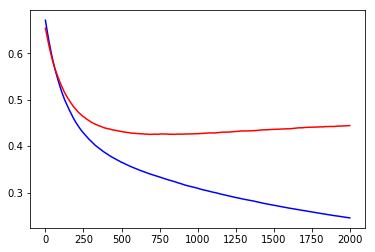

In [21]:
# Разбиваем выборку на обучение и тест
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_train, 
                                                        y_train,
                                                        test_size=0.33, 
                                                        random_state=None)

LEARNING_RATE = 0.005
MAX_DEPTH = 4
SUBSAMPLE = 0.75
MAX_FEATURES = 0.5
LEAF = 8

# Создаем класс модели градиентного бустинга
clf = GradientBoostingClassifier(n_estimators=2000, 
                                 learning_rate=LEARNING_RATE,
                                 max_depth=MAX_DEPTH, 
                                 subsample=SUBSAMPLE,
                                 max_features=MAX_FEATURES,
                                 min_samples_leaf=LEAF)

# Обучаем модель на обучающей выборке
clf.fit(X_train_, y_train_)

test_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_test_)):
    test_score[i] = log_loss(y_test_, y_pred)
    
train_score = np.zeros((clf.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(clf.staged_predict_proba(X_train_)):
    train_score[i] = log_loss(y_train_, y_pred)

# Находим оптимальное число итераций на тесте
print(np.argmin(test_score), np.min(test_score))

# Выводим зависимость качества от числа итераций
plt.plot(range(len(train_score)), train_score, 'b-',
         range(len(test_score)), test_score, 'r-')

##### Берем 841

## Строим модели с учетом подобранных параметров

In [15]:


# инициализирем модели с подобранными гиперпараметрами
rf_estimator = RandomForestClassifier(n_estimators=200,
                                      max_depth=9,
                                      max_features="log2",
                                      random_state=RANDOM_STATE)
gb_estimator = GradientBoostingClassifier(n_estimators=841, 
                                 learning_rate=0.005,
                                 max_depth=4, 
                                 subsample=0.75,
                                 max_features=0.5,
                                 min_samples_leaf=8)

# получаем предсказания вероятностей ансамблей на кросс-валидации для обучающей выборки
rf_train_pred = cross_val_predict_proba(rf_estimator, X_train, y_train)


gb_train_pred = cross_val_predict_proba(gb_estimator, X_train, y_train)
X_train_stack = np.stack([rf_train_pred[:,1], gb_train_pred[:,1]], axis=1)

# получаем предсказания ансамблей для тестовой выборки
rf_test_pred = rf_estimator.fit(X_train, y_train).predict_proba(X_test)
gb_test_pred = gb_estimator.fit(X_train, y_train).predict_proba(X_test)

X_test_stack = np.stack([rf_test_pred[:,1], gb_test_pred[:,1]], axis=1)

## Объединяем предсказания ансамблей с помощью логистической регрессии

In [16]:

params = {'model__penalty': ['l1', 'l2'],
         'model__C': range(1, 10000, 1000)}

pipeline = Pipeline([('model', LogisticRegression())])

grid = GridSearchCV(pipeline, param_grid=params, scoring=make_scorer(accuracy_score), cv=kfold)

grid.fit(X_train, y_train)

grid.best_params_

{'model__C': 1, 'model__penalty': 'l2'}

In [17]:
logreg = LogisticRegression(C=1.0, penalty='l2')
logreg.fit(X_train_stack, y_train)
logreg.coef_

array([[ 2.72613517,  2.47755189]])

## Формируем файл для отправки

In [18]:
predicted = rf_estimator.predict(X_test)
create_submission(predicted, 'submission_rf.txt')
# kaggle_score = 0.77033

In [19]:
predicted = gb_estimator.predict(X_test)
create_submission(predicted, 'submission_gb.txt')
# kaggle_score = 0.77990

In [20]:
predicted = logreg.predict(X_test_stack)
create_submission(predicted, 'submission.txt')
# kaggle_score = 0.77512

### Выводы
#### 1. Преодолеть целевой результат не получилось
#### 2. Стеккинг моделей не дал никакого прироста. Итоговый результат оказался ниже, чем результат GradientBoostingClasifier